In [ ]:
''' Objective: label units by cell type for concurrent analyses by FunKeys teammates

1. Use waveforms to identify fast spikeing (FS) cells
2. Use optotagging to identify SOM cell
3. All other cells will be considered generic excitatory cells
'''
import pandas as pd
import numpy as np
import scipy as scipy
import matplotlib.pyplot as plt
%matplotlib inline
from data.load_data import *
from data.ecephys import *
from data.cell_types import *
from sklearn.preprocessing import StandardScaler
import tensorflow_probability.substrates.jax.distributions as tfd
from dynamax.utils.utils import find_permutation
import seaborn as sns
import platform
platstring = platform.platform()
data_dirname = 'visual-behavior-neuropixels'
use_static = False
import statsmodels.stats.multitest as smStats

In [ ]:
cache = load_cache_behavior_neuropixel()

Starting with waveform analysis

In [ ]:
# fun_key function to get the stimulus presentations we're interested in
trial_df = get_trial_df(session)
# Adrian's function to get spikes and units
#units are already filtered for QC metrics
easySpikeMat, units=easy_spike_matrix_and_unit_table(cache, session, with_layer=False)

In [ ]:
units

In [ ]:
plt.hist(units.waveform_duration,bins=100,color='grey')
plt.xlabel('waveform duration')
plt.title('First mouse')

In [ ]:
units['FS']=False
units['FS'][units['waveform_duration']<.4]=True

In [ ]:
# units['FS'][units['waveform_duration']]
FS_counts = units.groupby('easy_name').FS.count()
FS_counts

In [ ]:
#units['FS'][units['easy_name']=='VISp']
plt.scatter(units[units['easy_name']=='VIS_med'].PT_ratio,units[units['easy_name']=='VIS_med'].recovery_slope,c=units[units['easy_name']=='VIS_med'].FS)
plt.xlabel('peak trough ratio')
plt.ylabel('recovery slope')
plt.title('First mouse')
# plt.ylim([-1.1, 0.1])
plt.xlim([0, 2])

Here I transition to the optotagging analysis

In [ ]:
ecephys_sessions_table = cache.get_ecephys_session_table()
example_sessions = [1053925378, 1081090969, 1064415305, 1108334384,1115356973]
example_sessions_table =ecephys_sessions_table.loc[example_sessions]
example_sessions_table

In [ ]:
session_id = example_sessions[3]
session = cache.get_ecephys_session(session_id)
print(session_id)

In [ ]:
# units_with_sst = find_SST_cells(session_id,session)

In [72]:
units =     units = session.get_units(amplitude_cutoff_maximum = 0.1, presence_ratio_minimum = 0.9,isi_violations_maximum = 0.5)
channels = session.get_channels()
units = units.merge(channels, left_on='peak_channel_id', right_index=True)

spike_times = session.spike_times
spike_times
opto_table = session.optotagging_table

#Make 3D array
time_before_laser = 0.5
trial_duration = 1.5
bin_size = 0.001
time_array = np.arange(-time_before_laser,trial_duration-time_before_laser,bin_size)

#opto_array has spike counts for each opto trial
opto_array,time = make_neuron_time_trials_array(units, spike_times,opto_table, time_before_laser, trial_duration, bin_size)

#Grab the short pulse + high power trials
duration = opto_table.duration.min() #choose the short duration
level = opto_table.level.max() #choose the high power

#Find the indicies of trials with this duration and level
sel_trials=((opto_table['duration']==duration)&(opto_table['level']==level)).values

#Average over these selected trials from the opto array
mean_opto_responses=np.nanmean(opto_array[:,:,sel_trials],2)

# find the time indices for a short window before and after optogenetic stimulation
time_idx = (time_array>=-0.05)&(time_array<0.05)

(-10.0, 20.0)

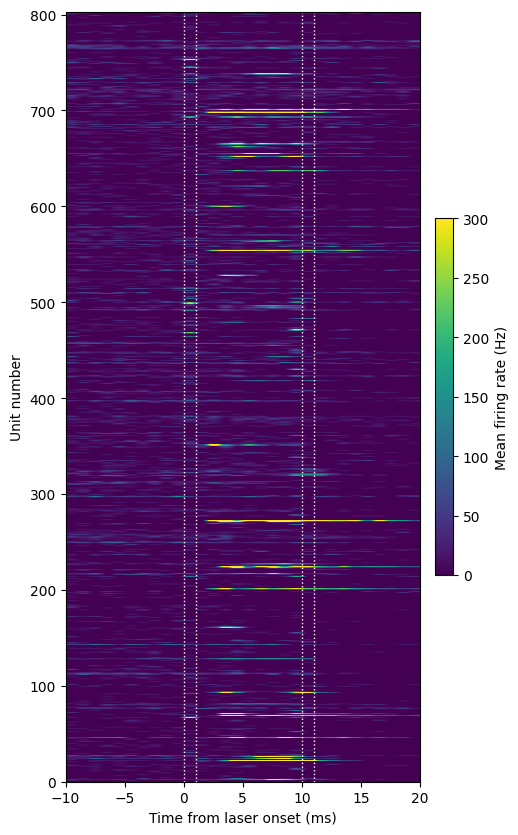

In [73]:
#Now plot a heatmap across units showing how they responded to the laser
fig,ax=plt.subplots(1,1)
fig.set_size_inches((5,10))

# Note: when using imshow, the "extent" parameter should match your data axes extent=[xmin, xmax, ymin, ymax].
# Since our bins are 1ms, and we are plotting from -50ms to +50ms, xmin=-50 and xmax=+50
# We also specify the y axis in terms of units, ymin=0 and ymax= the number of units we are plotting
im=ax.imshow(mean_opto_responses[:,time_idx],
             extent=[-50, 50, 0, mean_opto_responses.shape[0]], 
             origin='lower', aspect='auto')
min_clim_val = 0
max_clim_val = 300
im.set_clim([min_clim_val, max_clim_val])    
[ax.axvline(bound, linestyle=':', color='white', linewidth=1.0)\
     for bound in [0,1,11, 10]]
ax.set_xlabel('Time from laser onset (ms)')
ax.set_ylabel('Unit number')
cb = plt.colorbar(im,fraction=0.046, pad=0.04)
cb.set_label('Mean firing rate (Hz)')

ax.set_xlim([-10,20])

In [74]:
optoRespByTrial = opto_array[:,:,sel_trials]
optoRespByTrial.shape #nUnit x nTimepoints x nSelectedTrials

# slice our data array to take the baseline period (before the laser turns on)
baseline_time_idx = (time_array>=-0.010)&(time_array<-0.002)

# then average over this time window in the mean_opto_responses to get the baseline rate for each unit
baseline_rate = np.mean(optoRespByTrial[:,baseline_time_idx,:],1)
#nTrials nUnits
baseline_rate=baseline_rate.T

# do the same for the period when the laser was on to get the evoked rate for each unit, between 1ms and 9ms after the onset of the laser
evoked_rate_idx = (time_array>=0.001)&(time_array<0.009)
evoked_rate = np.mean(optoRespByTrial[:,evoked_rate_idx,:],1)
evoked_rate=evoked_rate.T

# do the wilcoxen test for each unit
optoT=[]
optoP=[]

# I now have the a nUnits array of baseline rates and an nUnits array of evoked rates for the selected stim paramters
for iCell in range(evoked_rate.shape[1]):
    thisBsln = baseline_rate[:,iCell]
    thisEvoked = evoked_rate[:,iCell]   
    try:
        this_optoT,this_optoP = sp.stats.wilcoxon(thisBsln,thisEvoked,alternative='less',zero_method='pratt')
        optoT.append(this_optoT)
        optoP.append(this_optoP)
    except(ValueError):
        optoT.append(0)
        optoP.append(1)


#correct for repeat testing
optoH,optoP_corrected,x1,x2=smStats.multipletests(optoP, alpha=0.05, method='hs')

InterNrn_opto_responses = mean_opto_responses[optoH==True]

/opt/conda/lib/python3.9/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/conda/lib/python3.9/site-packages/statsmodels/stats/multitest.py:177: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))


In [ ]:
optoH.shape

(-10.0, 20.0)

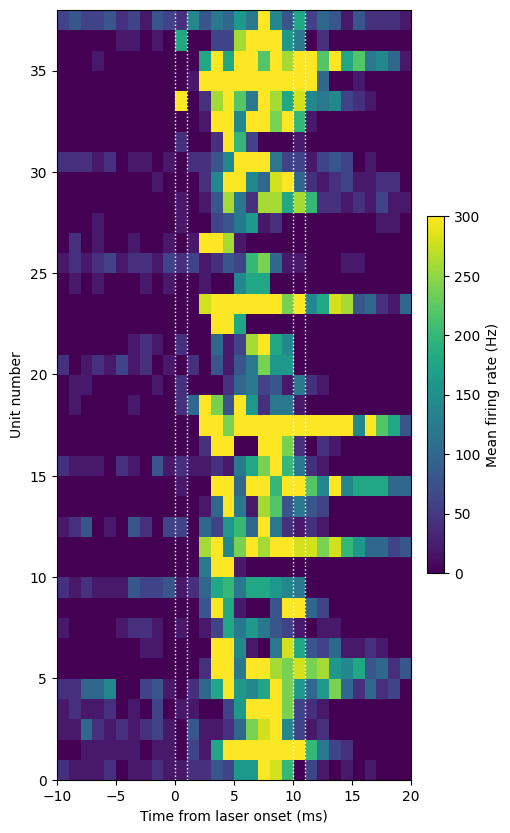

In [75]:
#plotting
#find the time indices for a short window before and after optogenetic stimulation
time_idx = (time_array>=-0.05)&(time_array<0.05)

#Now plot a heatmap across units showing how they responded to the laser
fig,ax=plt.subplots(1,1)
fig.set_size_inches((5,10))

# Note: when using imshow, the "extent" parameter should match your data axes extent=[xmin, xmax, ymin, ymax].
# Since our bins are 1ms, and we are plotting from -50ms to +50ms, xmin=-50 and xmax=+50
# We also specify the y axis in terms of units, ymin=0 and ymax= the number of units we are plotting
im=ax.imshow(InterNrn_opto_responses[:,time_idx],
             extent=[-50, 50, 0, InterNrn_opto_responses.shape[0]], 
             origin='lower', aspect='auto')
min_clim_val = 0
max_clim_val = 300
im.set_clim([min_clim_val, max_clim_val])    
[ax.axvline(bound, linestyle=':', color='white', linewidth=1.0)\
     for bound in [0,1,11, 10]]
ax.set_xlabel('Time from laser onset (ms)')
ax.set_ylabel('Unit number')
cb = plt.colorbar(im,fraction=0.046, pad=0.04)
cb.set_label('Mean firing rate (Hz)')

ax.set_xlim([-10,20])

In [76]:
optoH,optoP_corrected,x1,x2=smStats.multipletests(optoP, alpha=0.05, method='hs')
SST_opto_responses = mean_opto_responses[optoH==True]
units['SST']=optoH

In [ ]:
units.shape

In [77]:
SST_units=units[units['SST']==True]
SST_units.groupby('structure_acronym').SST.count()

structure_acronym
CA1      17
VISal     6
VISam     2
VISl      1
VISp      4
VISpm     5
VISrl     3
Name: SST, dtype: int64

In [ ]:
units